# Project Notebook


## Before you start:
* **Make your own copy** of this notebook
  * Select 'File' --> 'Save a copy in Drive...'
  * Add your name in front of the title of the notebook by clicking on the file name above.  

---
---
# Predicting Working Efficacy in Factory
---
---

***
## Authorship and Resources Used
* Weifan (Flora) Zhou
* Assistant: Brad Sheese
* Resources:
  * This forum discusses how to change features prefix. I used it for changing the feature names after dummy coding, replacing "recorded_comptype" with "pct". [Link](https://stackoverflow.com/questions/55679401/remove-prefix-or-suffix-substring-from-column-headers-in-pandas)
  * This forum discusses how to get Q3. I use it to discover outliers. [Link](https://stackoverflow.com/questions/45926230/how-to-calculate-1st-and-3rd-quartiles)
  * I used official document for calculating IQR. [Link](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.iqr.html)
  * I used the forum to see how to make linear regression in subplots when lmplots do not work. [Link](https://stackoverflow.com/questions/33049884/how-to-plot-2-seaborn-lmplots-side-by-side)
  * I used the forum to see how to adjust datapoints' transparency. [Link](https://stackoverflow.com/questions/47200033/how-to-adjust-transparency-alpha-in-seaborn-pairplot)

***
## Data Description and Source
* This dataset records daily working record of a factory. Every record include the labor's and their supervisor's information.
* Every worker has a supervisor, except for the production director. In the dataset, **"sub" indicates the labors themselves while "sup" means the supervisor**.
* The dataset include those parts:
  * Worker's personal information:
    * sub_ID / sup_ID: worker's ID / supervisor's ID
    * sub_fname / sub_lname / sup_fname / sup_lname: the worker and the supervisor's first and last name
    * sub_sex / sup_sex: the worker and the supervisor's gender
    * sub_shift: the person's working period. 1st shift indicates daytime, 3rd shift means overnight, and 2nd shift stays in the middle. The working shift never changes for each labor.
    * sub_team: the labor's team, which never changes for each labor. There are 24 teams. Each team corresponds to 1 supervisor.
    * sub_role / sup_role: the worker's position -- laborer, team leader (24 people), production director (1 person), or shift manager (3 people).
    * sub_coll_IDs: other workers' IDs in the same team.
    * sub_colls_same_sex_prtn: the percent of people with the same gender in the group. It changes as labors joining the factory or being fired.
  * Hidden information of the labor:
    * "_h" means data hidden in the system. They include three parts:
      * Daily assessments. They include: sub_health_h (the worker's self-assessment of health condition that day), behav_comptype_h (the worker's self-assumption of their performance in one day, including idea, sacrifice (work for the parts that others do not want to do), etc.), actual_efficacy_h (the worker's self record of their working efficacy).
      *  Worker's soft skill indexes, which are fixed. They include: commitment, perceptiveness, dexterity, sociality, goodness, strength, openmindedness, and workstyle.
      *  behav_cause_h: the resons of labors leaving the company (note: labors who are fired do not leave this note).
  * Supervisors' record about the labor:
    * recorded_efficacy: the supervisor's record about the worker's efficacy that day, which might be different from the worker's self-assessments
    * record_comptype: the supervisor's record about the worker's conditions that day, like idea, absence, feat, resignation... It has two extra conditions: termination (fire the labor) and onboarding (new labor joinas).
    * recorded_note_from_sup: some supervisor's notes about the person on that day. This column is for free writing and cannot be categorized.
    * record_conf_matrix_h: the supervisor may have different completion type record that labors' self-assessments. Those records will be labeled "false negative". Sometime the supervisor noticed the labor's action and confirmed those behaviors. Completion type with supervisor's confirmation will be labeled as "true positive".
  * Working date and time:
    * The dataset contains event date, weekday names (from Monday to friday), event_weekday_num (a count down of production cycle), event_week_in_series (total weeks started from the first record), and event_day_in_series (total weeks started from the first record).
* Data attribution:
  * Author: MATTHEW E. GLADDEN
  * Website: Kaggle
  * Link: [Factory Workers’ Daily Performance & Attrition](https://www.kaggle.com/datasets/gladdenme/factory-workers-daily-performance-attrition-s)
*  **Warning: the author did not describe what Groups A-E represents in "sub_workstyle_h" feature.**


***
## Research Question
* This project tries to predict labors' working efficacy in a factory and seek which factors have strongest relationship with working effectiveness.
* Working efficacy means how much work a labor has done. I wonder is age, softskills, health, and managers, which factor has more relationship with working outcomes.
* The prediction of working efficacy may be useful for managers to assign proper number of tasks to employees, making sure labors are able to finish work.

***
## Import Libraries and Set Preferences for Visualization

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

from scipy.stats import zscore
from scipy.stats import boxcox, shapiro
from scipy.stats import iqr
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/MyDrive/working_eff.csv"
df = pd.read_csv(path, encoding='ISO-8859-1')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***
## Read and Verify Data


Take an initial look at the dataframe.
There are two biggest problems:
1. Data is not in tidy format. On the same day, the record of labors appear more than once. And there are records for 364 days. Rows need to be merged -- one person should only have one row of data.
2. There are too many columns. Some features are not needed.

In [ ]:
# Initial look to data
df

,sub_ID,sub_fname,sub_lname,sub_age,sub_sex,sub_shift,sub_team,sub_role,sub_coll_IDs,sub_colls_same_sex_prtn,...,event_weekday_num,event_weekday_name,behav_comptype_h,behav_cause_h,actual_efficacy_h,record_comptype,record_cause,recorded_efficacy,recorded_note_from_sup,record_conf_matrix_h
0,98000001,Rebecca,Bauer,40,F,Shift 1,Team 1,Team Leader,"[98000002, 98000003, 98000004, 98000005, 98000...",0.714285714,...,4,Friday,Presence,None,None,Presence,None,None,None,None
1,98000001,Rebecca,Bauer,40,F,Shift 1,Team 1,Team Leader,"[98000002, 98000003, 98000004, 98000005, 98000...",0.714285714,...,4,Friday,Efficacy,None,1.489,Efficacy,None,1.2,None,None
2,98000002,Joan,Winter,61,F,Shift 1,Team 2,Team Leader,"[98000001, 98000003, 98000004, 98000005, 98000...",0.714285714,...,4,Friday,Presence,None,None,Presence,None,None,None,None
3,98000002,Joan,Winter,61,F,Shift 1,Team 2,Team Leader,"[98000001, 98000003, 98000004, 98000005, 98000...",0.714285714,...,4,Friday,Efficacy,None,1.023,Efficacy,None,0.8,None,None
4,98000003,Elizabeth,Martinez,20,F,Shift 1,Team 3,Team Leader,"[98000001, 98000002, 98000004, 98000005, 98000...",0.714285714,...,4,Friday,Presence,None,None,Presence,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411943,98000787,Sarah,Marino,28,F,Shift 3,Team 21,Laborer,"[98000428, 98000429, 98000430, 98000431, 98000...",0.526315789,...,3,Thursday,Sacrifice,None,None,Sacrifice,None,None,Sarah didnt complain when I suggested crawlin...,True Positive
411944,98000788,Theresa,Dahl,47,F,Shift 1,Team 6,Laborer,"[98000125, 98000127, 98000130, 98000131, 98000...",0.526315789,...,3,Thursday,Presence,None,None,Presence,None,None,None,None
411945,98000788,Theresa,Dahl,47,F,Shift 1,Team 6,Laborer,"[98000125, 98000127, 98000130, 98000131, 98000...",0.526315789,...,3,Thursday,Efficacy,None,0.261,Efficacy,None,0.3,None,None
411946,98000789,Paul,Gonzalez,34,M,Shift 2,Team 12,Laborer,"[98000247, 98000249, 98000251, 98000255, 98000...",0.315789474,...,3,Thursday,Presence,None,None,Presence,None,None,None,None


##### Keep only the record of labors
According to the descriptions on kaggle website, there are only 24 supervisors, 1 production leader, and 3 shift managers. The research focuses on predictions of laborer's efficacy rather than managers' efficacy. Meanwhile, managers only takes a small part of data.
Thus, managers' record can be dropped out.

In [ ]:
# We don't care about those who are not laborers
df = df[df['sub_role'] == 'Laborer']
df.head()

,sub_ID,sub_fname,sub_lname,sub_age,sub_sex,sub_shift,sub_team,sub_role,sub_coll_IDs,sub_colls_same_sex_prtn,...,event_weekday_num,event_weekday_name,behav_comptype_h,behav_cause_h,actual_efficacy_h,record_comptype,record_cause,recorded_efficacy,recorded_note_from_sup,record_conf_matrix_h
46,98000025,Samantha,Williams,20,F,Shift 1,Team 1,Laborer,"[98000026, 98000028, 98000030, 98000031, 98000...",0.368421053,...,4,Friday,Presence,None,None,Presence,None,None,None,None
47,98000025,Samantha,Williams,20,F,Shift 1,Team 1,Laborer,"[98000026, 98000028, 98000030, 98000031, 98000...",0.368421053,...,4,Friday,Efficacy,None,1.039,Efficacy,None,1.3,None,None
48,98000026,David,Ruiz,34,M,Shift 1,Team 1,Laborer,"[98000025, 98000028, 98000030, 98000031, 98000...",0.578947368,...,4,Friday,Presence,None,None,Presence,None,None,None,None
49,98000026,David,Ruiz,34,M,Shift 1,Team 1,Laborer,"[98000025, 98000028, 98000030, 98000031, 98000...",0.578947368,...,4,Friday,Efficacy,None,0.801,Efficacy,None,0.7,None,None
50,98000028,Mary,Phillips,40,F,Shift 1,Team 1,Laborer,"[98000025, 98000026, 98000030, 98000031, 98000...",0.368421053,...,4,Friday,Presence,None,None,Presence,None,None,None,None


#### Clean Data

There are a few problems:
1.   Some data types are incorrect. sub_ID (labors' ID) should be categorical, sub_colls_same_sex_prtn (the percent of members in a team with same gender), sup_age (the age of superivisers), actual efficacy, and recorded efficacy should be numeric.
2.   Some features are not useful for prediction, such as IDs and names.
3.   Some features play a same role as other features. For example, actual_efficacy_h and recorded_efficacy are almost the same; sub_coll_IDs  (ID's of people in the same team) is not necessary since on each role every person was listed which team they are in.
4.   There are some missing values.
4.   There are too many featues.



In [ ]:
# Inspect data. Look at features and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389184 entries, 46 to 411947
Data columns (total 42 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   sub_ID                   389184 non-null  int64  
 1   sub_fname                389184 non-null  object 
 2   sub_lname                389184 non-null  object 
 3   sub_age                  389184 non-null  int64  
 4   sub_sex                  389184 non-null  object 
 5   sub_shift                389184 non-null  object 
 6   sub_team                 389184 non-null  object 
 7   sub_role                 389184 non-null  object 
 8   sub_coll_IDs             389184 non-null  object 
 9   sub_colls_same_sex_prtn  389184 non-null  object 
 10  sub_health_h             389184 non-null  float64
 11  sub_commitment_h         389184 non-null  float64
 12  sub_perceptiveness_h     389184 non-null  float64
 13  sub_dexterity_h          389184 non-null  float64
 14  sub

Check missing values:
* All missing values are recorded as 'none' and cannot be detected by the info table before turning 'none' string into NAN.

In [ ]:
# Count missing values.
df = df.replace('None', np.nan)
df.isnull().sum(axis = 0)

sub_ID                          0
sub_fname                       0
sub_lname                       0
sub_age                         0
sub_sex                         0
sub_shift                       0
sub_team                        0
sub_role                        0
sub_coll_IDs                    0
sub_colls_same_sex_prtn       174
sub_health_h                    0
sub_commitment_h                0
sub_perceptiveness_h            0
sub_dexterity_h                 0
sub_sociality_h                 0
sub_goodness_h                  0
sub_strength_h                  0
sub_openmindedness_h            0
sub_workstyle_h                 0
sup_ID                          0
sup_fname                       0
sup_lname                       0
sup_age                         0
sup_sub_age_diff                0
sup_sex                         0
sup_role                        0
sup_commitment_h                0
sup_perceptiveness_h            0
sup_goodness_h                  0
event_date    

* Look at "sub_colls_same_sex_prtn" column and discover why there are missing values.
* We found those people are onboarding and thus are not working.

In [ ]:
# Take a look at rows with missing value at "sub_colls_same_sex_prtn" column
df.loc[df['sub_colls_same_sex_prtn'].isna()].head()

,sub_ID,sub_fname,sub_lname,sub_age,sub_sex,sub_shift,sub_team,sub_role,sub_coll_IDs,sub_colls_same_sex_prtn,...,event_weekday_num,event_weekday_name,behav_comptype_h,behav_cause_h,actual_efficacy_h,record_comptype,record_cause,recorded_efficacy,recorded_note_from_sup,record_conf_matrix_h
1059,98000611,Michelle,Lopez,23,F,Shift 1,Team 5,Laborer,"[98000106, 98000109, 98000110, 98000111, 98000...",NaN,...,4,Friday,Onboarding,NaN,NaN,Onboarding,NaN,NaN,NaN,NaN
1060,98000612,Nancy,Yoon,56,F,Shift 3,Team 22,Laborer,"[98000449, 98000450, 98000451, 98000452, 98000...",NaN,...,4,Friday,Onboarding,NaN,NaN,Onboarding,NaN,NaN,NaN,NaN
1061,98000613,Jason,Garcia,53,M,Shift 1,Team 5,Laborer,"[98000106, 98000109, 98000110, 98000111, 98000...",NaN,...,4,Friday,Onboarding,NaN,NaN,Onboarding,NaN,NaN,NaN,NaN
2117,98000614,Tonya,Wright,57,F,Shift 2,Team 12,Laborer,"[98000246, 98000247, 98000248, 98000249, 98000...",NaN,...,0,Monday,Onboarding,NaN,NaN,Onboarding,NaN,NaN,NaN,NaN
5274,98000615,Martha,Fischer,58,F,Shift 1,Team 3,Laborer,"[98000066, 98000067, 98000068, 98000069, 98000...",NaN,...,3,Thursday,Onboarding,NaN,NaN,Onboarding,NaN,NaN,NaN,NaN


In [ ]:
# Drop out rows of onboarding members
# Check if there are still missing values in "sub_colls_same_sex_prtn" columns
df = df[df['record_comptype'] != 'Onboarding']
df['sub_colls_same_sex_prtn'].isnull().sum() # The output shows how many missing values there are

0

* Look at which values there are in "recorded_cause" and "behave_cause_h".
* They all indicates the reason of leaving or being terminated. Our research topic do not focus on predicting leaving, and thus those two columns can be dropped.
* Meanwhile, drop out rows that contain "termination" or "resignation". They are not helpful for prediction working efficacy.

In [ ]:
# Look at which values there can be in "recorded_cause"
df['record_cause'].unique()

array([nan, 'Low Efficacy', 'Multiple Sabotages', 'Multiple Absences',
       'Multiple Disruptions', 'Multiple Lapses', 'Multiple Slips',
       'Lapses and Below-Average Efficacy'], dtype=object)

In [ ]:
# Look at which values there can be in "behave_cause_h"
df['behav_cause_h'].unique()

array([nan, 'Poor Teammates', 'Underrecorded Efficacy', 'Recruited Away',
       'Low Commitment', 'Ethically Inferior Supervisor'], dtype=object)

In [ ]:
df = df.drop(columns = ['record_cause', 'behav_cause_h'])

df = df[df['record_comptype'] != 'Termination']
df = df[df['record_comptype'] != 'Resignation']

* "Presence" and "Efficacy" means the same, and only “efficacy" rows contain working efficacy data. So, we drop "presence".
* Meanwhile, drop out records that was noted "false negative" -- the indicates there are some contributions that the supervisor did not notice.

In [ ]:
df = df[df['record_conf_matrix_h'] != 'False Negative']
df = df[df['record_comptype'] != 'Presence']

df = df.drop(columns = ['record_conf_matrix_h'])
df.head()

,sub_ID,sub_fname,sub_lname,sub_age,sub_sex,sub_shift,sub_team,sub_role,sub_coll_IDs,sub_colls_same_sex_prtn,...,event_date,event_week_in_series,event_day_in_series,event_weekday_num,event_weekday_name,behav_comptype_h,actual_efficacy_h,record_comptype,recorded_efficacy,recorded_note_from_sup
47,98000025,Samantha,Williams,20,F,Shift 1,Team 1,Laborer,"[98000026, 98000028, 98000030, 98000031, 98000...",0.368421053,...,1/1/2021,1,1,4,Friday,Efficacy,1.039,Efficacy,1.3,NaN
49,98000026,David,Ruiz,34,M,Shift 1,Team 1,Laborer,"[98000025, 98000028, 98000030, 98000031, 98000...",0.578947368,...,1/1/2021,1,1,4,Friday,Efficacy,0.801,Efficacy,0.7,NaN
51,98000028,Mary,Phillips,40,F,Shift 1,Team 1,Laborer,"[98000025, 98000026, 98000030, 98000031, 98000...",0.368421053,...,1/1/2021,1,1,4,Friday,Efficacy,0.924,Efficacy,0.7,NaN
53,98000030,Edward,Anderson,39,M,Shift 1,Team 1,Laborer,"[98000025, 98000026, 98000028, 98000031, 98000...",0.578947368,...,1/1/2021,1,1,4,Friday,Efficacy,0,Efficacy,0,NaN
55,98000031,Stephen,Robinson,40,M,Shift 1,Team 1,Laborer,"[98000025, 98000026, 98000028, 98000030, 98000...",0.578947368,...,1/1/2021,1,1,4,Friday,Efficacy,0.475,Efficacy,0.4,NaN


Check duplicated values. We did not found any duplicates.

In [ ]:
df.loc[df.duplicated() == True]

,sub_ID,sub_fname,sub_lname,sub_age,sub_sex,sub_shift,sub_team,sub_role,sub_coll_IDs,sub_colls_same_sex_prtn,...,event_date,event_week_in_series,event_day_in_series,event_weekday_num,event_weekday_name,behav_comptype_h,actual_efficacy_h,record_comptype,recorded_efficacy,recorded_note_from_sup


###Drop Features

Since there are too many features, we need to reduce some of them.

In [ ]:
# See how many unique values there are in each feature
df.nunique()

sub_ID                       654
sub_fname                     99
sub_lname                    100
sub_age                       48
sub_sex                        2
sub_shift                      3
sub_team                      24
sub_role                       1
sub_coll_IDs                3732
sub_colls_same_sex_prtn       13
sub_health_h                 382
sub_commitment_h             381
sub_perceptiveness_h         395
sub_dexterity_h              382
sub_sociality_h              392
sub_goodness_h               376
sub_strength_h               385
sub_openmindedness_h         384
sub_workstyle_h                5
sup_ID                        29
sup_fname                     23
sup_lname                     27
sup_age                       21
sup_sub_age_diff              85
sup_sex                        2
sup_role                       1
sup_commitment_h              28
sup_perceptiveness_h          28
sup_goodness_h                29
event_date                   434
event_week

* Since there are only laborers, we don't need information about worker's positions and their supervisor's positions.
* And there are only 24 supervisors, it is not a good idea to use supervisor's gender as a predictor.
* Meanwhile, since there is a feature showing the age difference between the labor and the supervisor, we don't need supervisor's age.

In [ ]:
df = df.drop(columns = ['sub_role', 'sup_role', 'sup_sex', 'sup_age'])

* "Recorded_efficacy" and "actual_efficacy" have similar data, so we drop one of them.
* There are only 24 teams, and thus for many people's record "sub_colls_same_sex_prtn" (same-gender rate) can be the same. This research use linear regression instead of Poisson, and thus it is better to drop this feature.

In [ ]:
df = df.drop(columns = ['actual_efficacy_h', 'sub_colls_same_sex_prtn'])

Correct some datatypes.

In [ ]:
# Correct some datatypes
df['sup_sub_age_diff'] = df['sup_sub_age_diff'].astype(int)
df['recorded_efficacy'] = df['recorded_efficacy'].astype(float)
df['sub_ID'] = df['sub_ID'].astype("string")

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204812 entries, 47 to 411947
Data columns (total 33 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   sub_ID                  204812 non-null  string 
 1   sub_fname               204812 non-null  object 
 2   sub_lname               204812 non-null  object 
 3   sub_age                 204812 non-null  int64  
 4   sub_sex                 204812 non-null  object 
 5   sub_shift               204812 non-null  object 
 6   sub_team                204812 non-null  object 
 7   sub_coll_IDs            204812 non-null  object 
 8   sub_health_h            204812 non-null  float64
 9   sub_commitment_h        204812 non-null  float64
 10  sub_perceptiveness_h    204812 non-null  float64
 11  sub_dexterity_h         204812 non-null  float64
 12  sub_sociality_h         204812 non-null  float64
 13  sub_goodness_h          204812 non-null  float64
 14  sub_strength_h     

* To avoid hand coding, this loop will filter out some features.
* For example, if there are too many non-numeric unique values in categorical variables, those variables should be dropped.
* Those containing only 1 values should be dropped, too.
* 24 teams are too many to do visualization, so drop the team feature.
* Note: I will not drop IDs at this moment because this feature is useful for grouping rows.


In [ ]:
drop_list = []

print("Number of rows and columns before dropping:")
print(df.shape)

# Drop features for categorical variables
for col in df.select_dtypes(include = 'object'):
  if df[col].nunique() > 12 or df[col].nunique() == 1:
    drop_list.append(col)

# Drop some int variable
for col in df.select_dtypes(include = 'int'):
  if df[col].nunique() < 45 or df[col].nunique() > 100:
    drop_list.append(col)

df = df.drop(drop_list, axis = 1)

print("")
print(df.columns)
print("")
print("Number of rows and columns after dropping:")
print(df.shape)

Number of rows and columns before dropping:
(204812, 33)

Index(['sub_ID', 'sub_age', 'sub_sex', 'sub_shift', 'sub_health_h',
       'sub_commitment_h', 'sub_perceptiveness_h', 'sub_dexterity_h',
       'sub_sociality_h', 'sub_goodness_h', 'sub_strength_h',
       'sub_openmindedness_h', 'sub_workstyle_h', 'sup_sub_age_diff',
       'event_week_in_series', 'event_weekday_name', 'behav_comptype_h',
       'record_comptype', 'recorded_efficacy'],
      dtype='object')

Number of rows and columns after dropping:
(204812, 19)


Drop event days. This research does not use Poisson regression or focuses on individual's daily performance, time and dates are not useful here.

In [ ]:
# Keep dropping some features
df = df.drop(columns = ['event_week_in_series', 'event_weekday_name'])
df = df.drop(columns = ['behav_comptype_h'])

print("Number of rows and columns after dropping:")
print(df.shape)
print(df.columns)

Number of rows and columns after dropping:
(204812, 16)
Index(['sub_ID', 'sub_age', 'sub_sex', 'sub_shift', 'sub_health_h',
       'sub_commitment_h', 'sub_perceptiveness_h', 'sub_dexterity_h',
       'sub_sociality_h', 'sub_goodness_h', 'sub_strength_h',
       'sub_openmindedness_h', 'sub_workstyle_h', 'sup_sub_age_diff',
       'record_comptype', 'recorded_efficacy'],
      dtype='object')


#### Dummy Coding

* Since there are different completion type records in "record_comptype" column, it becomes hard to merge data into a tidy format. So, I will do dummy coding, which is going to be helpful for counting the total number of each completion type.

In [ ]:
# Create columns for dummy variables and turn them into "0 and 1" forms
if not 'record_comptype_Slip' in df.columns:
  df = pd.get_dummies(df, columns = ['record_comptype'])

df.describe().T

,count,mean,std,min,25%,50%,75%,max
sub_age,204812.0,41.505488,13.710529,18.000,30.000,41.000,53.000,65.000
sub_health_h,204812.0,0.744878,0.154590,0.153,0.651,0.765,0.859,1.000
sub_commitment_h,204812.0,0.751006,0.148239,0.172,0.653,0.764,0.866,0.999
sub_perceptiveness_h,204812.0,0.742351,0.157609,0.169,0.644,0.763,0.868,1.000
sub_dexterity_h,204812.0,0.741998,0.149804,0.240,0.646,0.761,0.859,1.000
sub_sociality_h,204812.0,0.736702,0.163763,0.152,0.633,0.751,0.863,1.000
sub_goodness_h,204812.0,0.738837,0.145550,0.290,0.637,0.754,0.849,1.000
sub_strength_h,204812.0,0.736067,0.164235,0.215,0.625,0.760,0.870,0.999
sub_openmindedness_h,204812.0,0.759123,0.157460,0.270,0.664,0.778,0.884,1.000
sup_sub_age_diff,204812.0,-1.308253,19.318696,-45.000,-16.000,0.000,13.000,43.000


In [ ]:
# Look at the datatypes of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204812 entries, 47 to 411947
Data columns (total 25 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   sub_ID                      204812 non-null  string 
 1   sub_age                     204812 non-null  int64  
 2   sub_sex                     204812 non-null  object 
 3   sub_shift                   204812 non-null  object 
 4   sub_health_h                204812 non-null  float64
 5   sub_commitment_h            204812 non-null  float64
 6   sub_perceptiveness_h        204812 non-null  float64
 7   sub_dexterity_h             204812 non-null  float64
 8   sub_sociality_h             204812 non-null  float64
 9   sub_goodness_h              204812 non-null  float64
 10  sub_strength_h              204812 non-null  float64
 11  sub_openmindedness_h        204812 non-null  float64
 12  sub_workstyle_h             204812 non-null  object 
 13  sup_sub_age_d

* These steps are going to group rows and make the messy dataset into a tidy format.
* Since some workers stay longer in the company, while others stay comes lately to the factory, it is better to use rate (for example, slip rate) than just counting total numbers of each kind of completion.
* Rows will be grouped by IDs following those principles:
  * For integer variables such as age, each person's row will adopt the minimum value because the dataset spans more than 300 days, and people's age grows.
  * Values in float columns will become the mean value of all rows. For changing features like working efficacy, use mean value will get the average value. For fixed values such as sub_openmindness_h, the mean value will not change the original value.
  * For dummy variable, all 0s and 1s will be added up using sum. This step is going to be helpful for getting the rates (like slip rate) for each column.
  * Other categorical variables (object) will be merged and show up their first value appears, since values in those columns do not change as time goes.
* After grouping the dataset into tidy format, IDs will be dropped.

In [ ]:
# Divide columns into 4 parts based on their types
binary_cols = df.select_dtypes(include = 'uint8').columns
int_cols =  df.select_dtypes(include = 'int64').columns
obj_cols = df.select_dtypes(include = 'object').columns
float_cols =  df.dropna().select_dtypes(include = 'float64').columns

# Group rows
binary_grouped = df.groupby('sub_ID')[binary_cols].sum().reset_index() # group dummy variables into sum
int_grouped = df.groupby('sub_ID')[int_cols].min().reset_index() # group int variables into min
float_grouped = df.groupby('sub_ID')[float_cols].mean().reset_index() # group float variables into mean
obj_cols = df.groupby('sub_ID')[obj_cols].first().reset_index() # group objects into each person's first value

# Merge grouped table
result = pd.merge(obj_cols, int_grouped, on='sub_ID')
result = pd.merge(result, float_grouped, on='sub_ID')
result = pd.merge(result, binary_grouped, on='sub_ID')

# Drop IDs
df = result.drop(columns = ['sub_ID'])

* Here is another problem: the age difference between supervisors and laborers are shown either negative or positive. I took the absolute value.
* Change datatypes. For example, change "objects" into "category" for readability.
* Note: I change 'record_comptype_Efficacy' into float. Otherwise, when I try to divide an integer by integer, the result is not going to be a float.
* Meanwhile, get the rate of each completion type, and change the name of columns.

In [ ]:
# Turn age difference into absolute value
df['sup_sub_age_diff'] = df['sup_sub_age_diff'].abs()

# This line is a trick. I will use it later to get "idea rate", "feat rate", etc.
df['record_comptype_Efficacy'] = df['record_comptype_Efficacy'].astype(float)

# Change "object" type into "category"
for col in df.select_dtypes(include = 'object'):
  df[col] = df[col].astype('category')

# Get the absence rate
df['record_comptype_Absence'] = df['record_comptype_Absence'] / (df['record_comptype_Efficacy'] + df['record_comptype_Absence'])

# Get other rates
for col in df.select_dtypes(include = 'uint64'):
  df[col] = df[col] / df['record_comptype_Efficacy']

# Drop "record_comptype_Efficacy" column because we already have absence rate
df = df.drop(columns = ['record_comptype_Efficacy'])

# Change name of columns because we are using percentage (pct)
for col in df.columns:
    if 'record_comptype' in col:
        new_name = col.replace('record_comptype', 'pct')
        df.rename(columns = {col: new_name}, inplace=True)

df

,sub_sex,sub_shift,sub_workstyle_h,sub_age,sup_sub_age_diff,sub_health_h,sub_commitment_h,sub_perceptiveness_h,sub_dexterity_h,sub_sociality_h,...,recorded_efficacy,pct_Absence,pct_Disruption,pct_Feat,pct_Idea,pct_Lapse,pct_Sabotage,pct_Sacrifice,pct_Slip,pct_Teamwork
0,F,Shift 1,Group A,20,20,0.433,0.975,0.799,0.894,0.718,...,0.576819,0.048718,0.008086,0.013477,0.026954,0.005391,0.0,0.024259,0.002695,0.010782
1,M,Shift 1,Group B,34,6,0.776,0.782,0.909,0.922,0.851,...,0.931915,0.038363,0.007979,0.023936,0.018617,0.005319,0.0,0.021277,0.000000,0.013298
2,F,Shift 1,Group C,40,0,0.859,0.503,0.779,0.761,0.789,...,0.775532,0.035897,0.002660,0.010638,0.021277,0.005319,0.0,0.026596,0.005319,0.021277
3,M,Shift 1,Group B,39,1,0.806,0.426,0.460,0.741,0.732,...,0.928117,0.033333,0.015915,0.021220,0.007958,0.015915,0.0,0.023873,0.002653,0.015915
4,M,Shift 1,Group D,40,0,0.685,0.961,0.535,0.531,0.934,...,0.626400,0.015748,0.000000,0.008000,0.008000,0.012000,0.0,0.032000,0.016000,0.024000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
649,F,Shift 2,Group C,57,4,0.713,0.705,0.779,0.949,0.843,...,0.815000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.050000,0.000000,0.000000
650,M,Shift 1,Group A,30,29,0.905,0.704,0.878,0.786,0.925,...,0.609091,0.000000,0.090909,0.181818,0.000000,0.000000,0.0,0.000000,0.000000,0.090909
651,F,Shift 3,Group C,28,3,0.749,0.801,0.763,0.795,0.593,...,0.681818,0.000000,0.000000,0.000000,0.000000,0.090909,0.0,0.090909,0.000000,0.000000
652,F,Shift 1,Group A,47,19,0.436,0.926,0.813,0.781,0.706,...,0.575000,0.000000,0.000000,0.000000,0.000000,0.250000,0.0,0.000000,0.000000,0.000000


***
## Analyses and Visualizations
* This part check distribution of each feature, correct skewness, and make linear regression with r-squared value printed.


### Check Distribution with Visualization

For numerical features, first look at their distributions

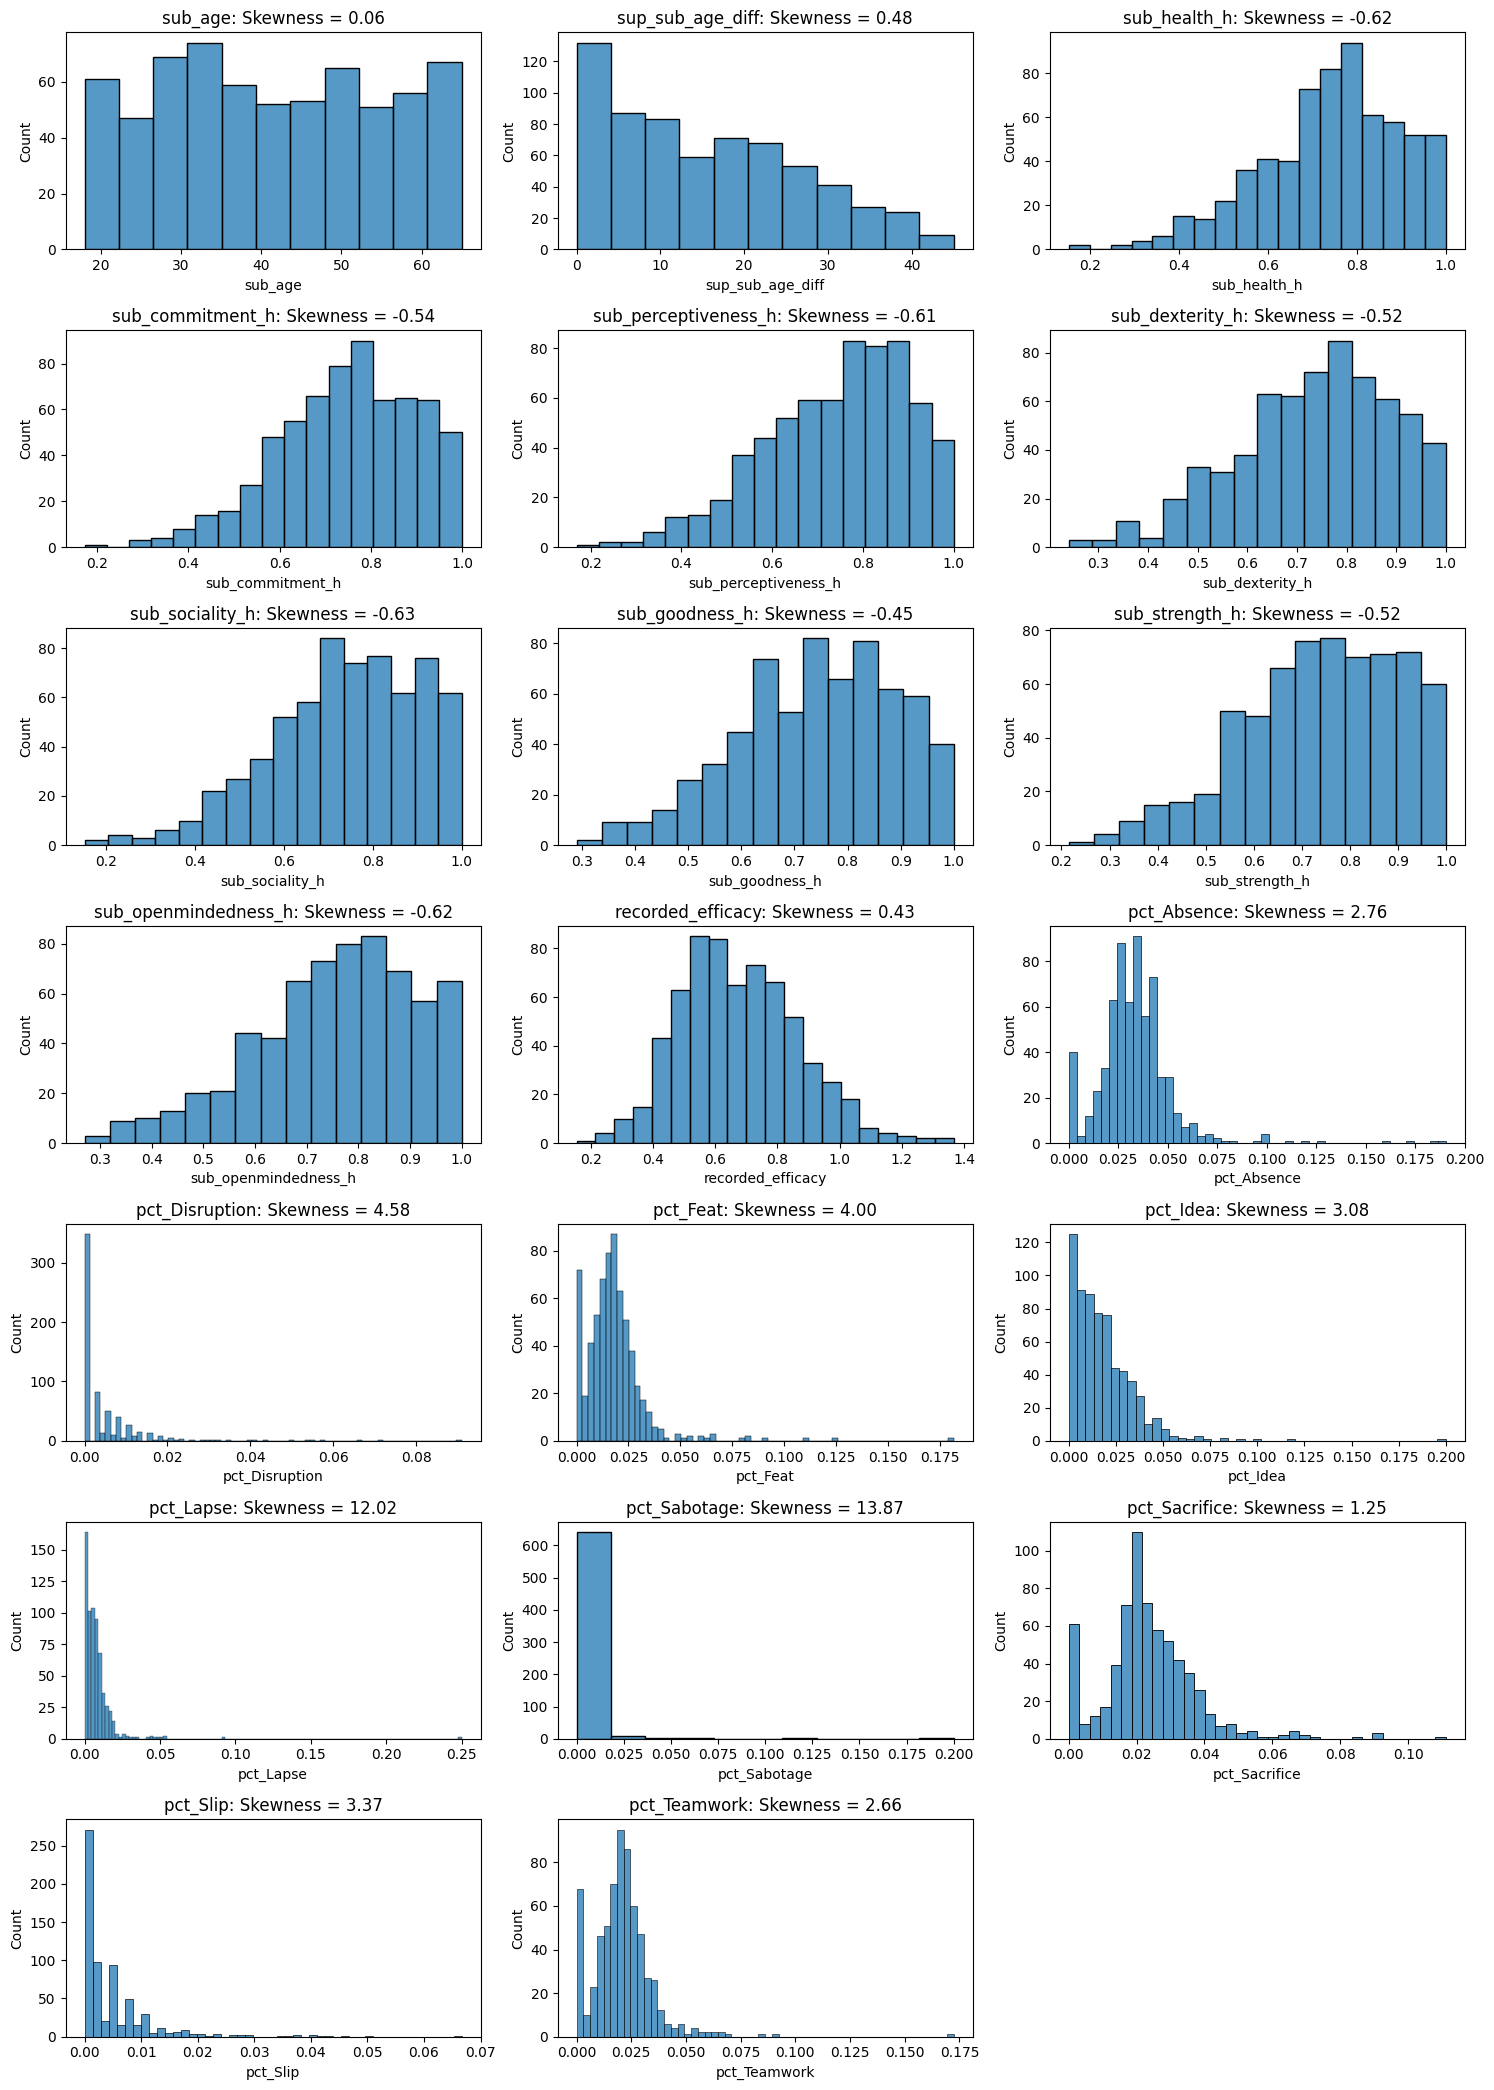

In [ ]:
# Helper function of subplots from Prof Sheese.
def hist_plots(features):
  # Calculate the number of rows and columns for the subplots
  num_features = len(features)
  num_cols = 3  # Three columns per row
  num_rows = (num_features + num_cols - 1) // num_cols  # Calculate the number of rows needed

  # Create a figure with subplots
  fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

  # Flatten the axes array for easy iteration
  axes = axes.flatten()

  # Make subplots
  for subplot_counter, feature in enumerate(features):
      ax = axes[subplot_counter]
      sns.histplot(data=df, x=feature, ax=ax)
      ax.set_title(f'{feature}: Skewness = {df[feature].skew():.2f}')  # Update skewness value here

  # Remove any empty subplots if the number of features is not a multiple of three
  for i in range(num_features, num_rows * num_cols):
      fig.delaxes(axes[i])

  # Adjust spacing and display the plots
  plt.tight_layout()
  plt.show()

hist_plots(df.select_dtypes(exclude = 'category').columns)

We note that there are some features that are unbalanced and severely skewed. For unbalanced data, we turn them into categorical.

In [ ]:
# For severely unbalanced features, turn them into categorical data
into_category = []

# Count the total number of 0s in each column
# Calculate the percentage of 0s in that column
for col in df.select_dtypes(exclude = 'category'):
  zero_mask = (df[col] == 0)
  zero_count = df.loc[zero_mask, col].shape[0]
  zero_percent = zero_count/df.shape[0]

  # If more than 75% of values are 0 in that column
  # Make non-zero values into 1 and turn that feature into categorical data
  if zero_percent > 0.75:
    df.loc[~zero_mask, col] = 'Yes'
    df.loc[zero_mask, col] = 'No'
    df[col] = df[col].astype('category')
    into_category.append(col)

    # Rename that column because that feature is no longer percentage
    if 'pct' in col:
      new_name = col.replace('pct', 'bool')
      df.rename(columns = {col: new_name}, inplace=True)

print(into_category)

['pct_Sabotage']


In [ ]:
# Double check variable types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 654 entries, 0 to 653
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   sub_sex               654 non-null    category
 1   sub_shift             654 non-null    category
 2   sub_workstyle_h       654 non-null    category
 3   sub_age               654 non-null    int64   
 4   sup_sub_age_diff      654 non-null    int64   
 5   sub_health_h          654 non-null    float64 
 6   sub_commitment_h      654 non-null    float64 
 7   sub_perceptiveness_h  654 non-null    float64 
 8   sub_dexterity_h       654 non-null    float64 
 9   sub_sociality_h       654 non-null    float64 
 10  sub_goodness_h        654 non-null    float64 
 11  sub_strength_h        654 non-null    float64 
 12  sub_openmindedness_h  654 non-null    float64 
 13  recorded_efficacy     654 non-null    float64 
 14  pct_Absence           654 non-null    float64 
 15  pct_Di

For categorical data, make bar plots to visualize what's their relationship with working efficacy.

In [ ]:
# Helper function
# Original code from Prof Sheese
def bar_plots(features):
  # Calculate the number of rows and columns for the subplots
  num_features = len(features)
  num_cols = 2  # Two columns per row
  num_rows = (num_features + num_cols - 1) // num_cols  # Calculate the number of rows needed

  # Create a figure with subplots
  fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 5 * num_rows))

  # Flatten the axes array for easy iteration
  axes = axes.flatten()

  # Make subplots
  for subplot_counter, feature in enumerate(features):
      ax = axes[subplot_counter]
      sns.barplot(data=df, y='recorded_efficacy', x=feature, ax=ax)
      means = df.groupby(by=feature).mean(numeric_only=True)['recorded_efficacy'].round(2)

  # Remove any empty subplots if the number of features is not a multiple of three
  for i in range(num_features, num_rows * num_cols):
      fig.delaxes(axes[i])

  # Adjust spacing and display the plots
  plt.tight_layout()
  plt.show()

Warning here: the dataset author did not provide any descriptions with what group A-E means.

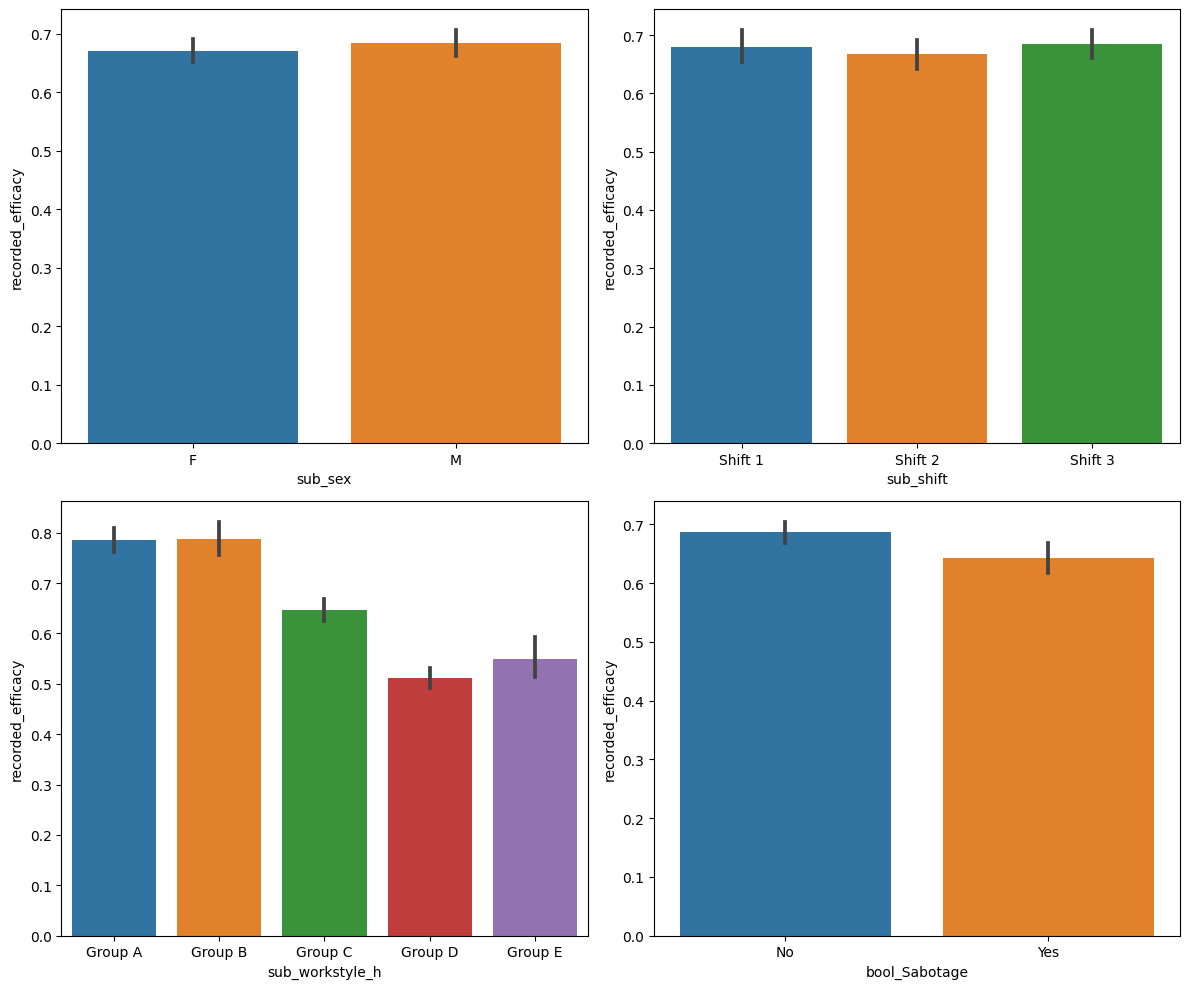

In [ ]:
bar_plots(df.select_dtypes(include = 'category').columns)

#### Correct Skewness and Catch Outliers

Use box-cox transformation to correct skewness.

In [ ]:
# For skewed data, correct skewness use box-cox transformation
# Original code from Prof Sheese's homework
for feature in df.select_dtypes(exclude = 'category'):
    skewness = df[feature].skew()

    #If skewness is larger than 0.4 or smaller than -0.4, apply transformation
    if skewness > 0.4 or skewness < -0.4:
        # Ensure all data is positive before applying Box-Cox
        if (df[feature] <= 0).any():
            df[feature] = df[feature] - df[feature].min() + 1

        df[feature], _ = boxcox(df[feature])

Detect outliers using IQR, and bin them into the maximum value.

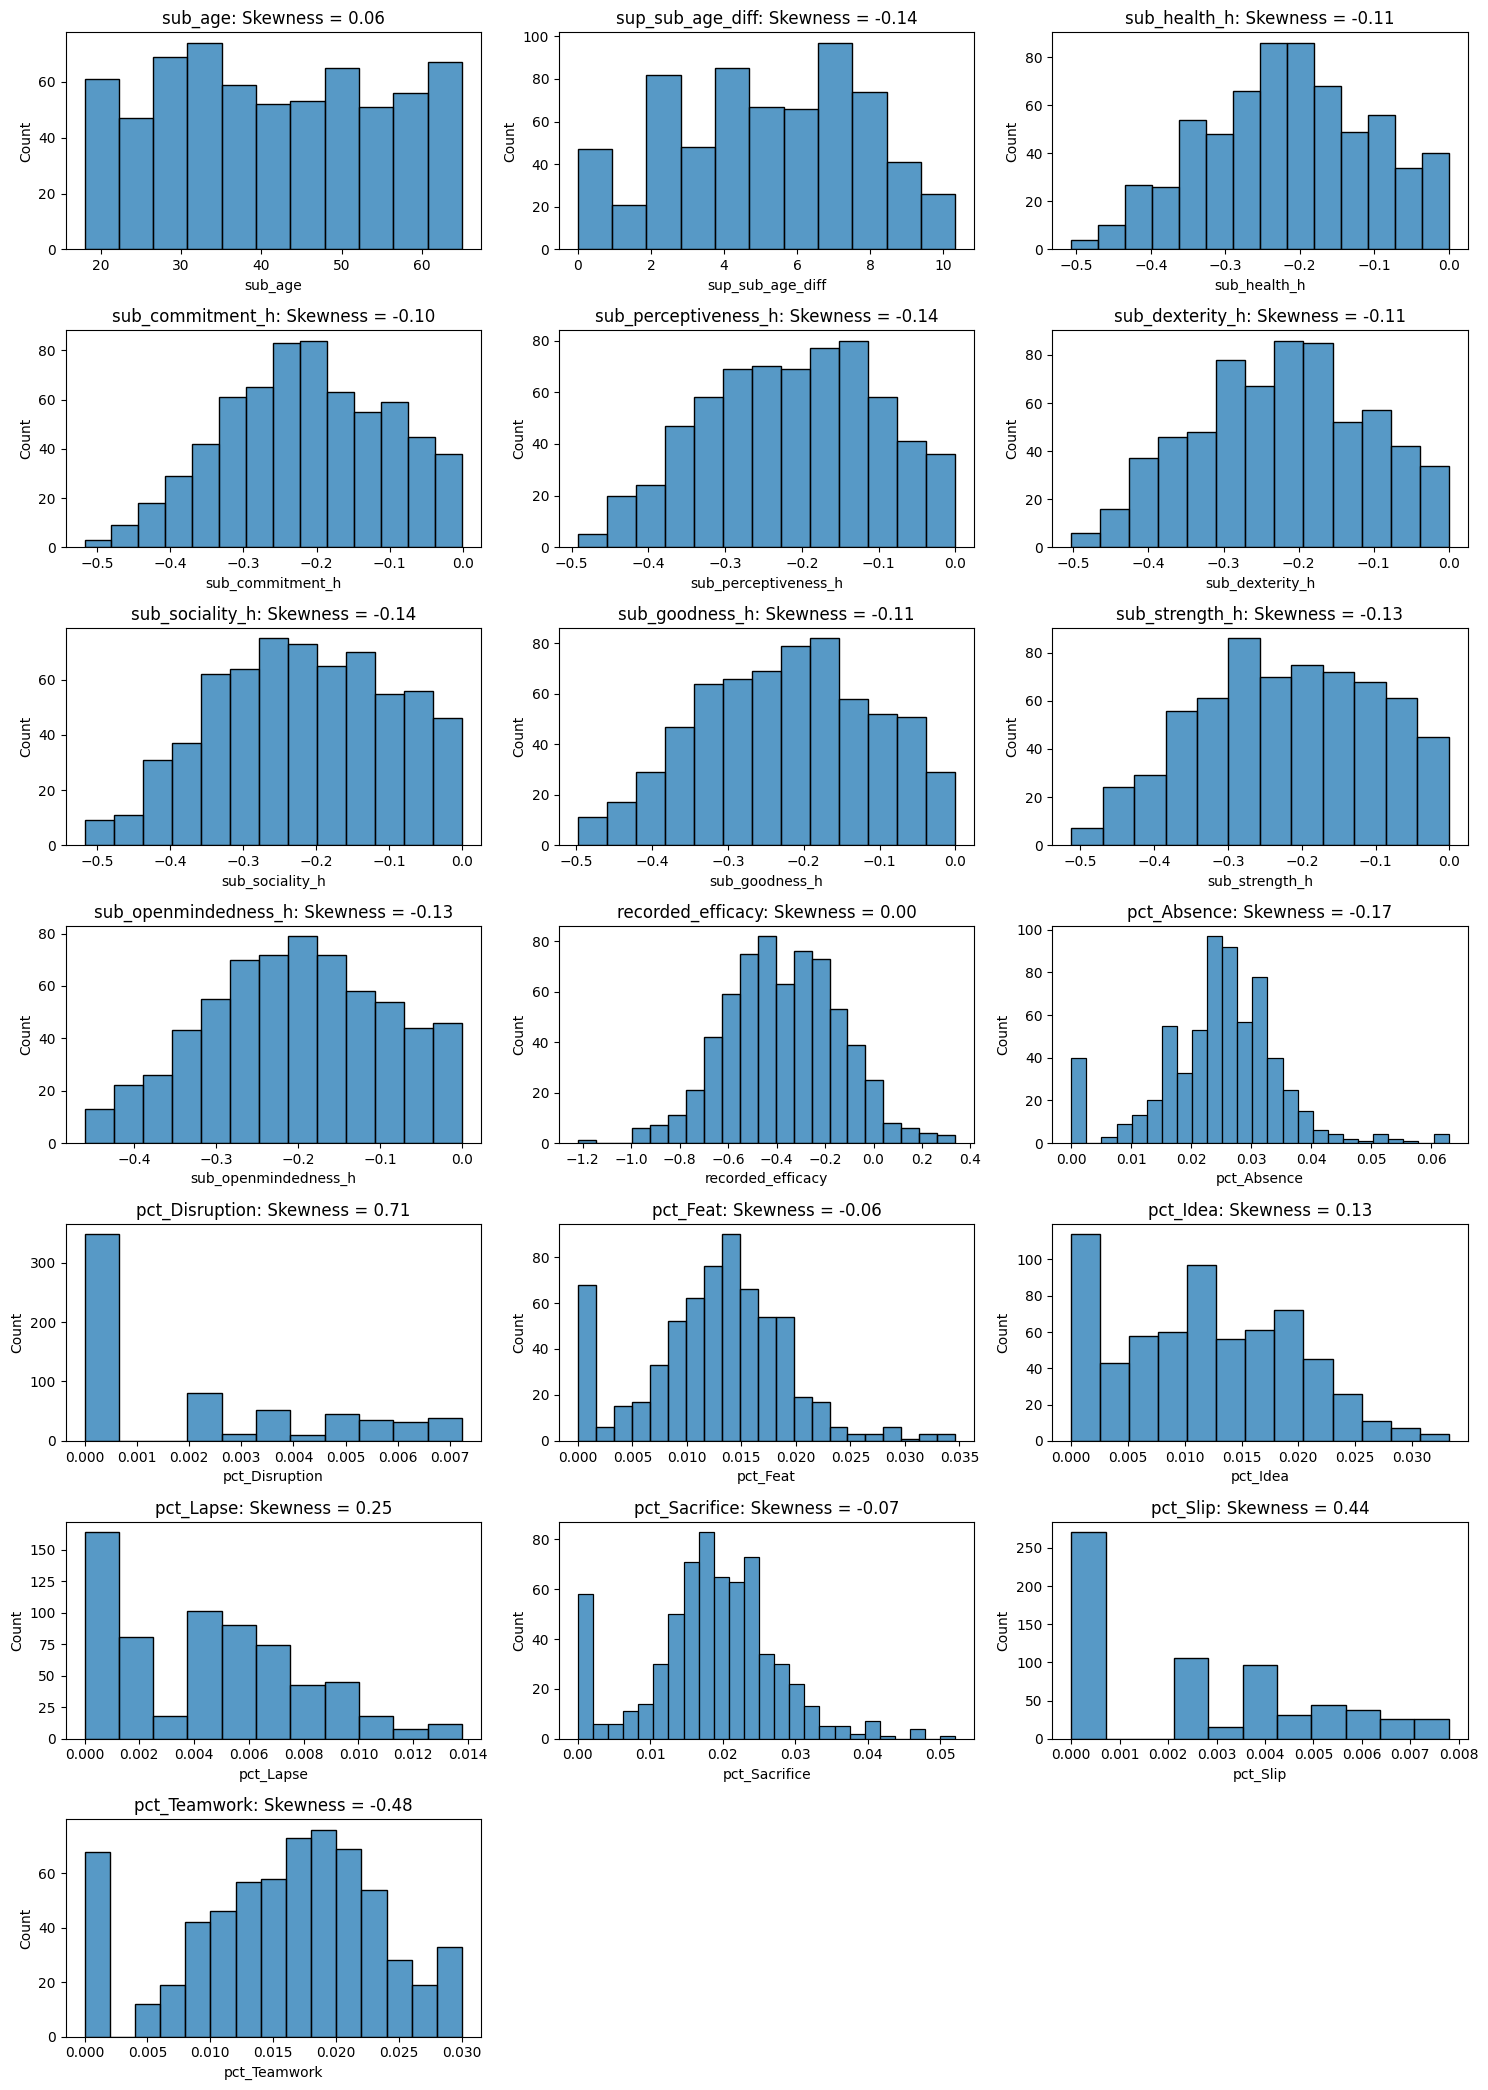

In [ ]:
# If there are outliers, shift that outlier into the maximum value
for feature in df.select_dtypes(exclude = 'category'):
  max = np.percentile(df[col], 75) + iqr(df[col], axis=0)

  max_mask = (df[col] > max)
  df.loc[max_mask, col] = max

hist_plots(df.select_dtypes(exclude = 'category').columns)

In [ ]:
# Look at current distributions of data after transformation
num_cols = df.select_dtypes(include=[np.number]).columns
df.loc[:, num_cols] = df.loc[:, num_cols].apply(zscore)
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
sub_age,654.0,0.0,1.0,-1.72,-0.84,-0.03,0.84,1.72
sup_sub_age_diff,654.0,0.0,1.0,-1.99,-0.79,0.05,0.81,1.97
sub_health_h,654.0,-0.0,1.0,-2.61,-0.69,0.01,0.74,1.94
sub_commitment_h,654.0,-0.0,1.0,-2.70,-0.72,-0.00,0.77,1.91
sub_perceptiveness_h,654.0,0.0,1.0,-2.51,-0.74,0.06,0.79,1.92
sub_dexterity_h,654.0,0.0,1.0,-2.46,-0.72,0.05,0.76,1.96
sub_sociality_h,654.0,-0.0,1.0,-2.48,-0.72,-0.00,0.78,1.82
sub_goodness_h,654.0,0.0,1.0,-2.42,-0.75,0.01,0.77,1.95
sub_strength_h,654.0,0.0,1.0,-2.45,-0.74,0.02,0.83,1.84
sub_openmindedness_h,654.0,0.0,1.0,-2.34,-0.71,0.01,0.76,1.84


### Correlation and Linear Regression

Get correlations between different features and efficacy.

In [ ]:
# Calculate the correlation (absolute value) and sort them.
df.corr()['recorded_efficacy'].sort_values(ascending=False)

<ipython-input-34-4fc6e1da1a59>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()['recorded_efficacy'].sort_values(ascending=False)


recorded_efficacy       1.000000
sub_age                 0.318213
pct_Disruption          0.263692
pct_Idea                0.243950
sub_commitment_h        0.102534
sub_goodness_h          0.078333
pct_Teamwork            0.044391
pct_Sacrifice           0.042979
sub_health_h            0.034984
pct_Absence             0.032575
sub_dexterity_h         0.031806
sub_sociality_h        -0.008330
sub_openmindedness_h   -0.019639
pct_Lapse              -0.026345
sub_strength_h         -0.052040
pct_Feat               -0.061267
sub_perceptiveness_h   -0.071283
pct_Slip               -0.097337
sup_sub_age_diff       -0.516636
Name: recorded_efficacy, dtype: float64

In [ ]:
# Helper function of subplots
# Revised from the histogram subplots
def combined_lmplots(df, y_name: str):
  features = df.loc[:, df.columns != y_name].select_dtypes(exclude = 'category').columns

  y = np.array(df[y_name]).reshape(-1,1)

  # Calculate the number of rows and columns for the subplots
  num_features = len(features)
  num_cols = 3  # Three columns per row
  num_rows = (num_features + num_cols - 1) // num_cols  # Calculate the number of rows needed

  # Create a figure with subplots
  fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 35))

  # Flatten the axes array for easy iteration
  axes = axes.flatten()

  # Plot out regression lines
  for subplot_counter, feature in enumerate(features):
      ax = axes[subplot_counter]
      sns.regplot(x = feature, y = 'recorded_efficacy', data = df, scatter_kws={'alpha': 0.3}, ax = ax)

      X = np.array(df[feature]).reshape(-1, 1)

      # create the model
      model = LinearRegression()

      # fit the data
      model.fit(X,y)

      ax.set_title(f'{feature}: R-squared = {model.score(X, y):.2f}')

  # Remove any empty subplots if the number of features is not a multiple of three
  for i in range(num_features, num_rows * num_cols):
      fig.delaxes(axes[i])

  # Adjust spacing and display the plots
  plt.tight_layout()
  plt.show()

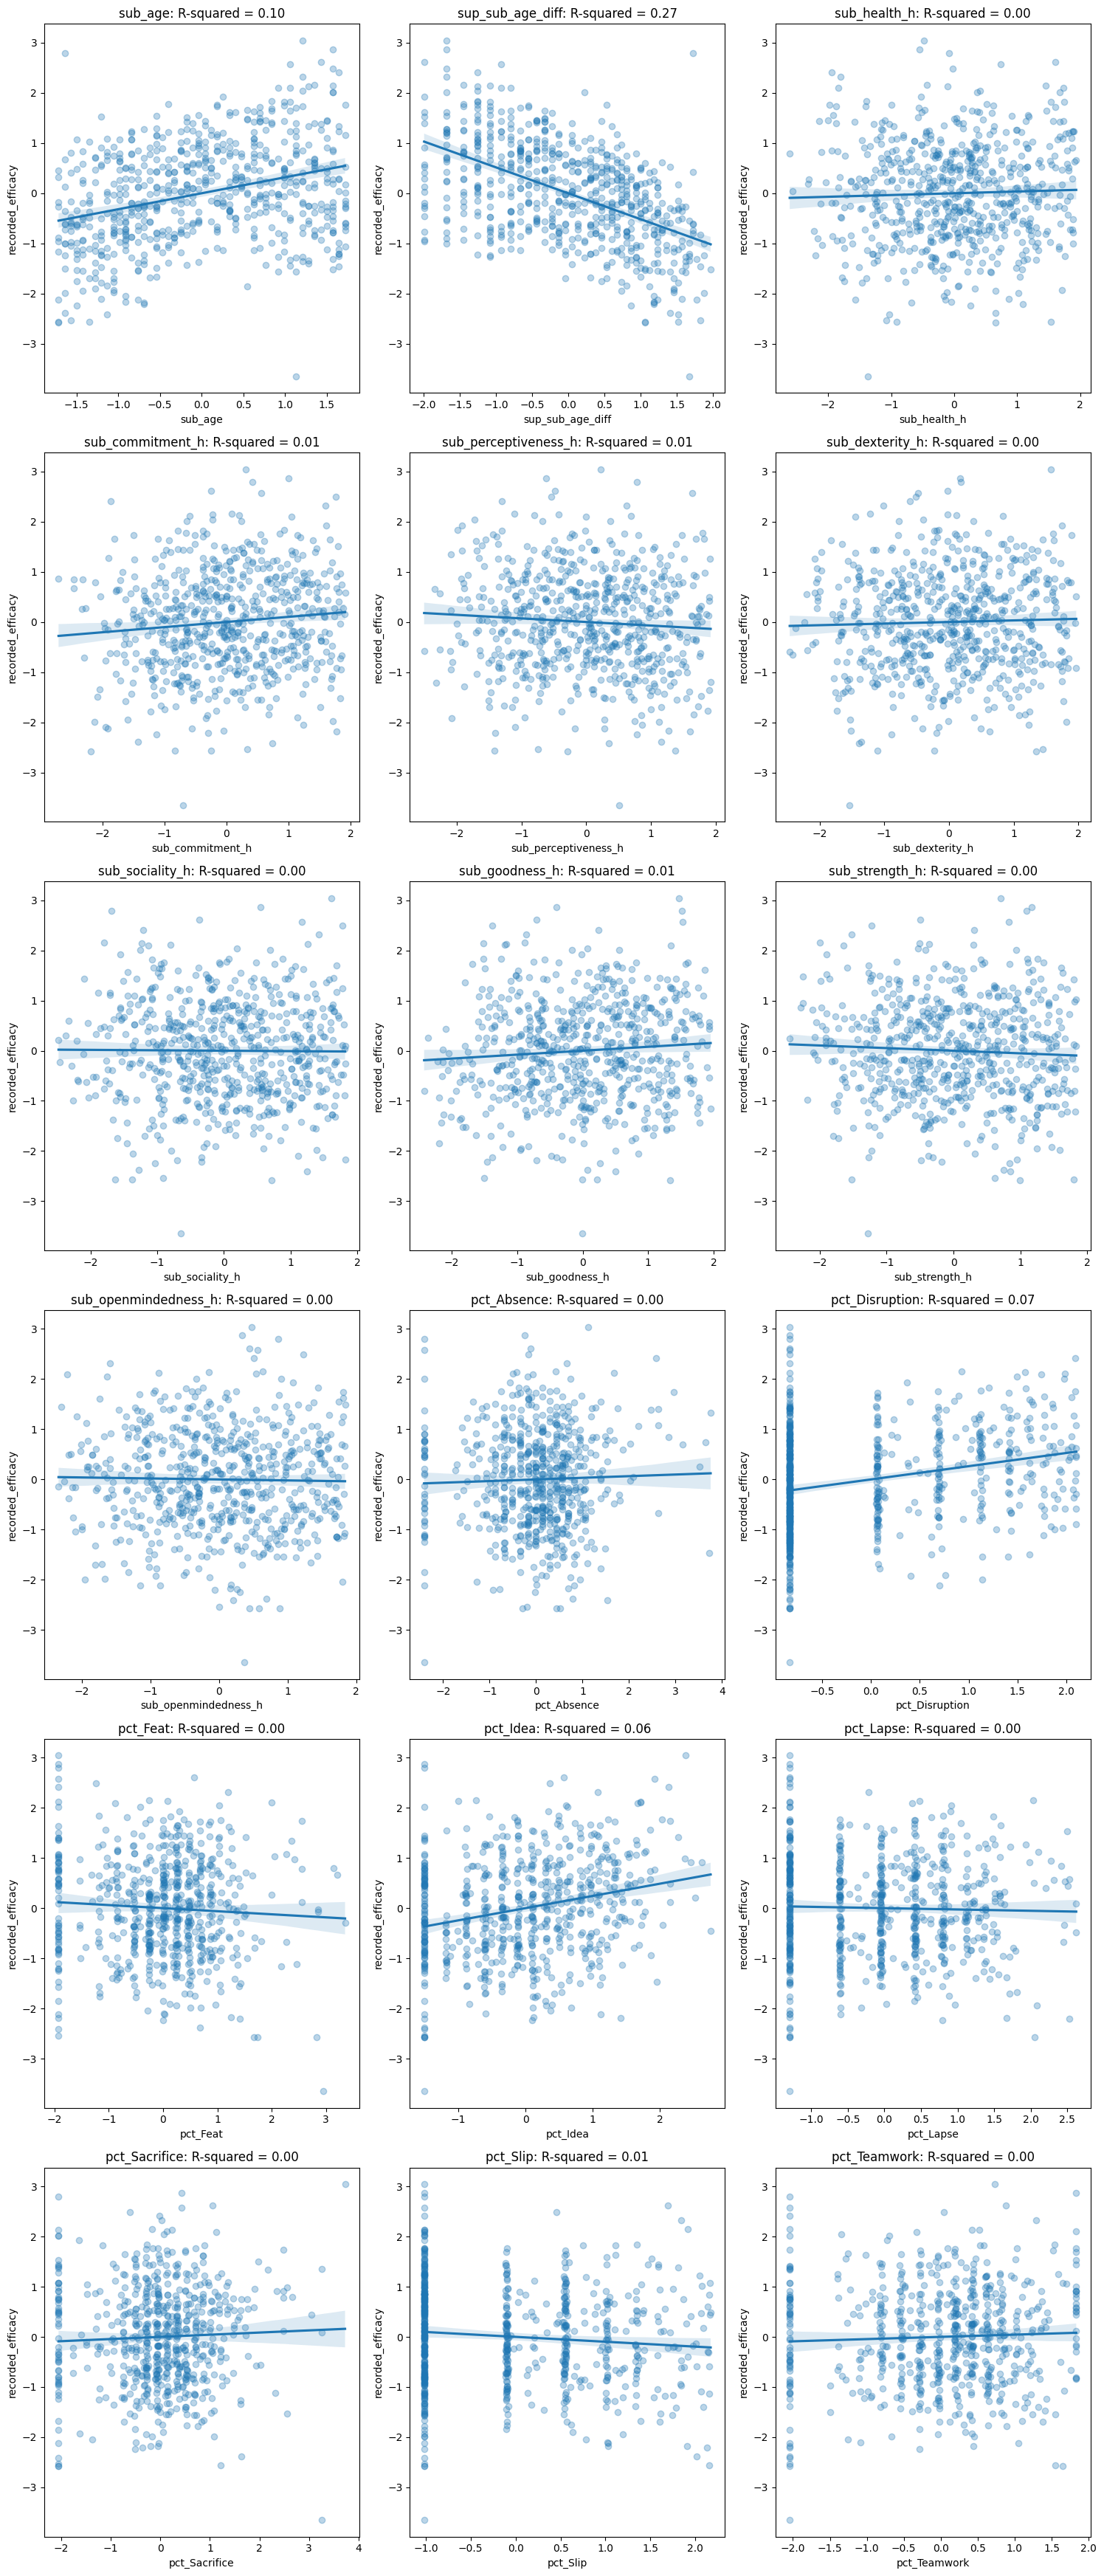

In [ ]:
combined_lmplots(df, 'recorded_efficacy')

### Compare Between Different Values in Categorical variables

For age and age difference, two most significant predictors, see what happens after considering categorical values.

In [ ]:
def compare_subplts(X_name: str, y_name: str):
  model = LinearRegression()

  for feature in df.select_dtypes(include = 'category'):
    sns.lmplot(x = X_name, y = y_name, data = df, scatter_kws={'s': 20, 'alpha': 0.3}, hue = feature)
    plt.show()

    print("===R-Squared===")

    # Loop over each unique option in each categorical value
    # Get the r-squared value for each option
    for option in df[feature].unique():
      y = np.array(df.loc[df[feature] == option][y_name]).reshape(-1,1)
      X = np.array(df.loc[df[feature] == option][X_name]).reshape(-1,1)
      model.fit(X, y)
      print(str(option) + ": " + str(model.score(X, y).round(2)))

    print("----------------------------")

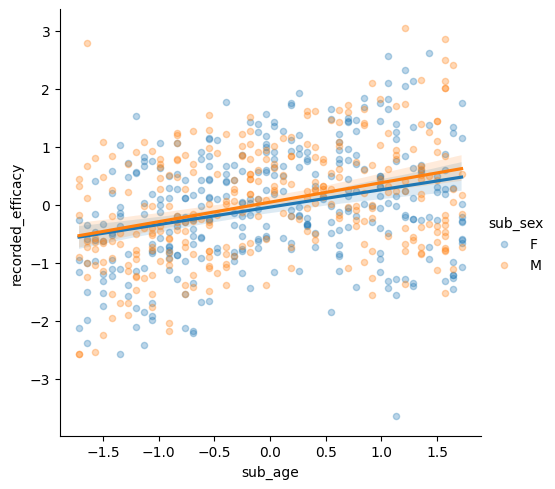

===R-Squared===
F: 0.09
M: 0.12
----------------------------


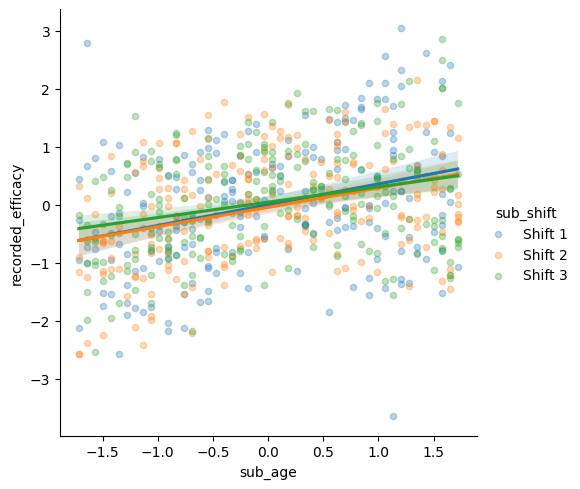

===R-Squared===
Shift 1: 0.1
Shift 2: 0.12
Shift 3: 0.08
----------------------------


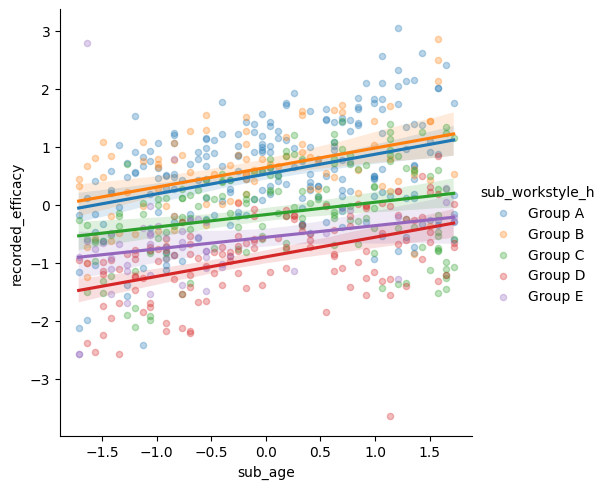

===R-Squared===
Group A: 0.13
Group B: 0.2
Group C: 0.08
Group D: 0.23
Group E: 0.06
----------------------------


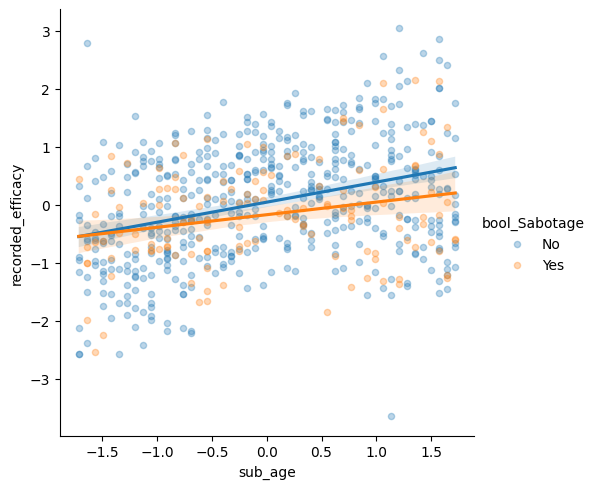

===R-Squared===
No: 0.11
Yes: 0.06
----------------------------


In [ ]:
  # Plot categorical data comparison in efficacy vs. age
  compare_subplts('sub_age', 'recorded_efficacy')

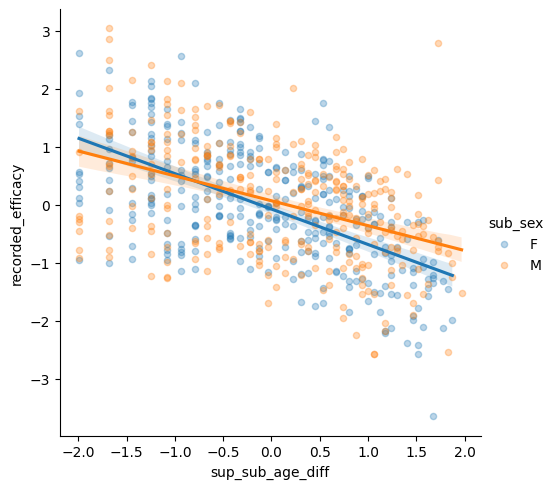

===R-Squared===
F: 0.36
M: 0.19
----------------------------


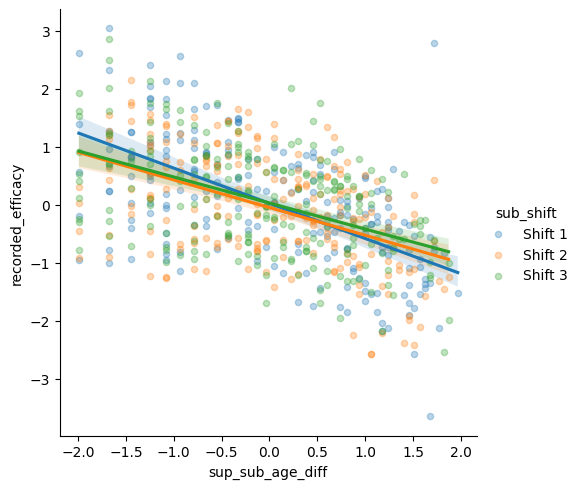

===R-Squared===
Shift 1: 0.34
Shift 2: 0.23
Shift 3: 0.22
----------------------------


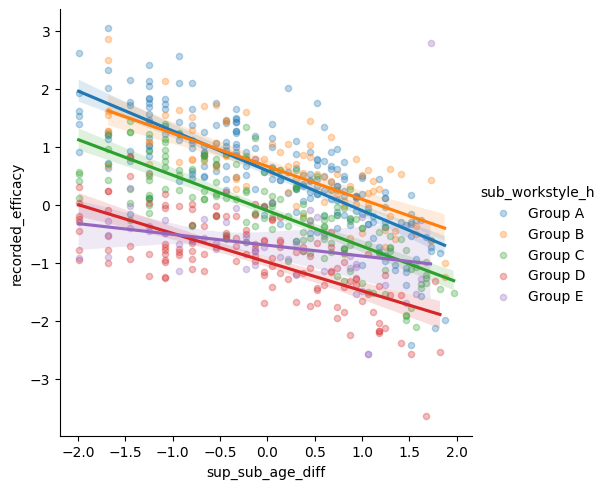

===R-Squared===
Group A: 0.61
Group B: 0.56
Group C: 0.6
Group D: 0.48
Group E: 0.06
----------------------------


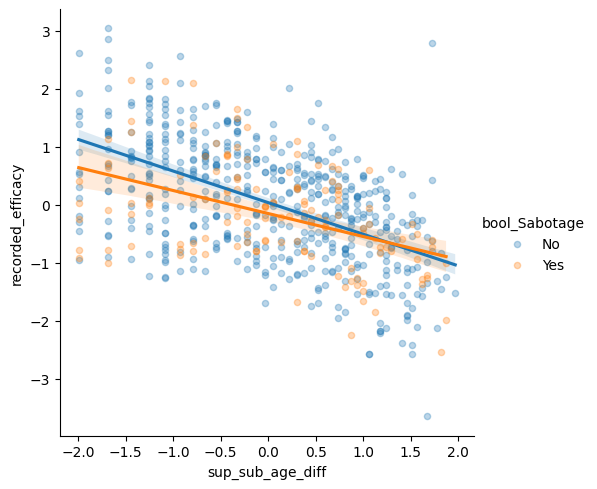

===R-Squared===
No: 0.28
Yes: 0.2
----------------------------


In [ ]:
# Plot categorical data comparison in efficacy vs. age-difference
compare_subplts('sup_sub_age_diff', 'recorded_efficacy')

Only working style have a significant difference between its groups. For other categorical features, there is not much difference.

***
## Conclusions
* For numerical features, laborer's age and age difference between supervisors and laborers, have linear association with working efficacy and can be regarded as predictors.
* Laborer's age has moderate positive correlation with working efficacy. Workers with larger age tend to have higher working efficacy.
* Age difference between labors and supervisors has a weak negative correlation with working efficacy. Laborers with supervisors whose age is similar to laborers tend to have higher working efficacy.
* For categorical data, work style type has a significant relationship with working efficacy. Laborers who are categorized into Group A or B has higher working efficacy.
* Limitations of my and conclusion: this project does not focus on mutiple linear regression. Meanwhile, since the dataset represents how working efficacy changes with time changes, use Poisson Regression may help get a better predictions. Meanwhile, since the dataset author did NOT provide much information about "sub_workstyle_h" and did NOT explain what Group A-E indicate, the project cannot interpret workstyle's relationship with working efficacy in a more specific way.


---
---

In [ ]:
#@title Completed the exercise?
#@markdown Click on the arrow to the left to create the submission form.

import os
import sys

tool_path = '/content/cs125_tools/'

if not os.path.exists(tool_path):
  ! git clone --quiet https://github.com/bsheese/cs125_tools.git

if tool_path not in sys.path:
  sys.path.append(tool_path)

import project_report_response as prr

prr.display_form(prr.er_question_list)


If this form does not display correctly in Colab, select "Runttime" from the menu at the top, then select "Restart and run all"
Your first name:


Text(value='Weifan', placeholder='Enter your first name here')


Your last name:


Text(value='Zhou', placeholder='Enter your last name here')


What class was this project for?


Dropdown(index=3, options=('None selected', 'CS/DS125', 'DS225', 'CS/DS377', 'CS380/DS395'), value='CS/DS377')


Which project are you submitting?


Dropdown(index=4, options=('None selected', '9.9.2 Visualizations - Multiple', '13.9.1 Correlations/Scatterplo…


Share your notebook.
Select 'Share' at the top of the screen. Then select 'Get Link'.
Change the Link so anyone can view it.
Click 'Copy Link', then 'Done'. Paste the link here.


Textarea(value='https://colab.research.google.com/drive/1RcWac7YDflxpC8MwMPcFyqhpEZLxJ5o5?usp=sharing', placeh…

In [ ]:
#@title Ready to Submit?
#@markdown If you have completed the project and the submission form:
#@markdown * check the box 'Ready' box below
#@markdown * execute this cell

Ready = True #@param {type:"boolean"}

try:
  if Ready == True:
    prr.submit_exercise_response(prr.er_question_list)

  else:
    print('NOT SUBMITTED!!!')
    print('Check the ready box if you are ready to submit your response.')

except:
  print('NOT SUBMITTED!!!')
  print('Execute the cell above to create the form.')

Exercise response submitted.
